### Imports

In [33]:
import cv2
import numpy as np
from scipy.spatial import distance

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

### Constants

In [34]:
PATH_FILE_PLATES = './file/in-plates.jpg'
PATH_FILE_PLATE_1 = './file/in-plate-01.jpg'
PATH_FILE_PLATE_2 = './file/in-plate-02.jpg'

## Plotting Utils

In [35]:

def plot3dSurface(
        fig, axis,
        z: np.array,
        x: np.array = None, y: np.array = None,
        meshGrid: np.array = None,
        position = (),
    ):
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    # Set surface mesh
    if not meshGrid == None and (not x or not y):
        raise AttributeError('No axis provided to plot a surface')

    meshGrid = meshGrid if (meshGrid != None) else np.meshgrid(x, y)
    x, y = meshGrid

    # Create surface
    surf = axis.plot_surface(x, y, z, cmap=cm.Reds)
    fig.colorbar(surf, aspect=5, shrink=.5, ax=axis)

    # axis.set_zlim(-1.01, 1.01)
    axis.zaxis.set_major_locator(LinearLocator(10)) # Alters the grid visible scale
    axis.zaxis.set_major_formatter('{x:.02f}')
    
    # Customize position
    if len(position):
        azim, elev, dist = position
        axis.azim = azim
        axis.elev = elev
        axis.dist = dist

def plot3dSurfacesGrid(
        surfaces: np.array,
        gridRows = 1, gridCols = 1,
        colHeight = 5, colWidth = 5,
        positions = [],
    ) -> None:
    '''
        TODO: 2021-10-27 - Finish Description
        
        About surface positions:

        - Azimuth: Rotation around the z axis;
        - Elev(ation)?: Angle between the eye and the xy plane;
        - Distance: Distance to the center of the surface space;

        Thanks to: https://stackoverflow.com/a/64849390/5959978
    '''
    
    # Build grid
    figHeight = gridRows * colHeight
    figWidth = gridCols * colWidth
    fig, axes = plt.subplots(subplot_kw={"projection": "3d"}, nrows=gridRows, ncols=gridCols, figsize=(figWidth, figHeight))

    # Plot surfaces
    for surfaceNumber in range(0, gridRows):
        for axisNumber in range(0, gridCols):
            x, y, z = surfaces[surfaceNumber]
            a = axes[surfaceNumber, axisNumber] if gridRows > 1 else axes[axisNumber]
            position = positions[axisNumber] if (len(positions) >= axisNumber) else ()
            plot3dSurface(fig=fig, axis=a, x=x, y=y, z=z, position=position)
    
    plt.show()


## Template Matching Class

In [31]:
class TemplateMatching():
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    __img = np.array([])
    __template = np.array([])
    __correlation = np.array([])

    def __init__(self, imgPath: str, templatePath: str) -> None:
        self.__img = self.__readGrayScaleImg(imgPath)
        self.__template = self.__readGrayScaleImg(templatePath)

    def match(self):
        '''
            TODO: 2021-10-27 - ADD Description
        '''


        self.__correlation = cv2.matchTemplate(self.__img, self.__template, cv2.TM_CCOEFF_NORMED)
        return self

    def getCovarMatrix(self) -> np.array:
        '''
            TODO: 2021-10-27 - ADD Description
        '''
        
        return self.__correlation

    def getImageDimensions(self) -> tuple:
        return self.__img.shape

    def getTemplateDimensions(self) -> tuple:
        return self.__template.shape

    # def drawRectangle(self, topLeft: tuple, bottomRight: tuple):
    #     '''
    #         TODO: 2021-10-27 - ADD Description
    #     '''
        
    #     cv2.rectangle(self.__img, topLeft, bottomRight, (255, 0, 0), 1) 
    #     return self

    def __readGrayScaleImg(self, path: str) -> np.array:
        '''
            TODO: 2021-10-26 - ADD Description
        '''

        imgBgr = cv2.imread(path)
        return np.array(cv2.cvtColor(imgBgr, cv2.COLOR_BGR2GRAY))


## Matching

### Default Open CV

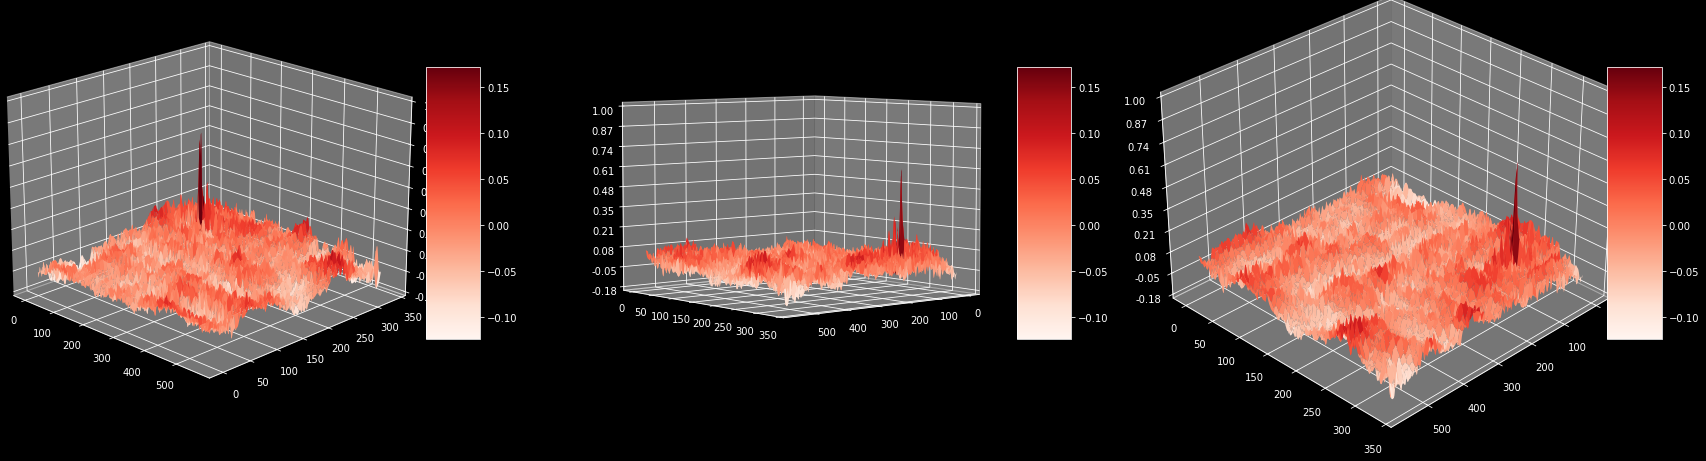

In [36]:

# Do the matching
templateMatcher = TemplateMatching(PATH_FILE_PLATES, PATH_FILE_PLATE_1)
covarMatrix = templateMatcher.match().getCovarMatrix()

# Build grid
meshX = np.arange(0, covarMatrix.shape[1], 1)
meshY = np.arange(0, covarMatrix.shape[0], 1)

surfaces = []

# Set the squared distances surface
surfaces.append( (meshX, meshY, covarMatrix) )

# Plot surfaces
plot3dSurfacesGrid(
    surfaces=surfaces,
    gridRows = 1, gridCols = 3,
    colHeight = 10, colWidth = 10,
    positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8)]
)

### Minkowski Distance

(334,) (560,) (560, 334)


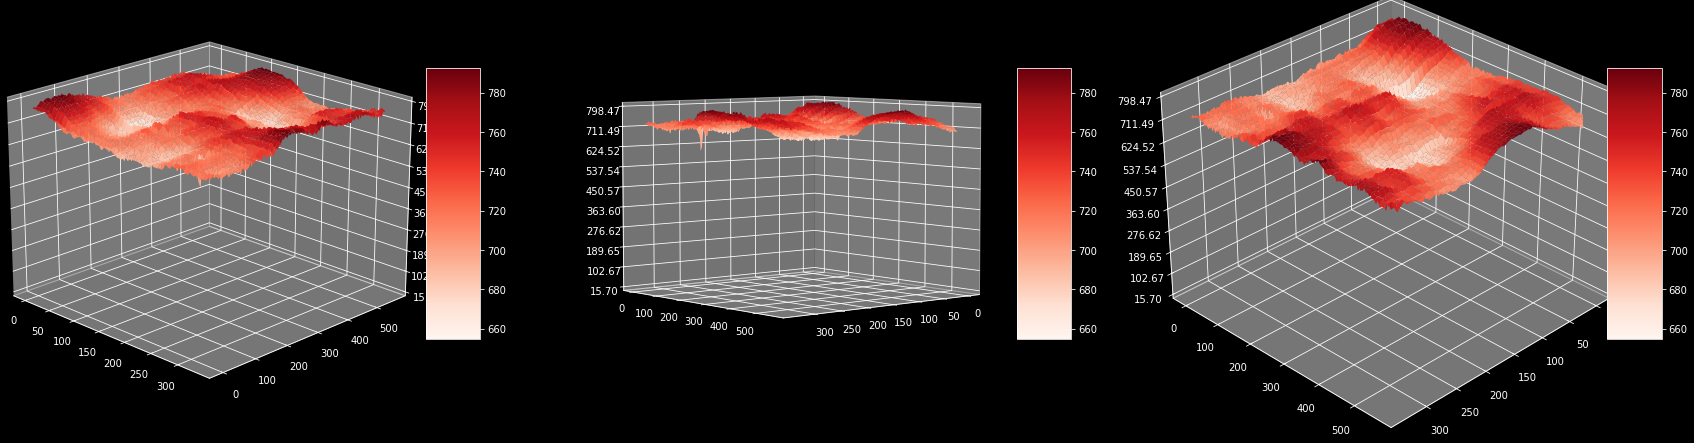

In [28]:

# Read images
imgRgb = cv2.imread(PATH_FILE_PLATES)
templateRgb = cv2.imread(PATH_FILE_PLATE_1)
    
imgGray = cv2.cvtColor(imgRgb, cv2.COLOR_BGR2GRAY).T
templateGray = cv2.cvtColor(templateRgb, cv2.COLOR_BGR2GRAY).T

iWidth, iHeight = imgGray.shape
tWidth, tHeight = templateGray.shape

# Calculate matrix of distances
p = 6 # Minkowski Power
tVec = templateGray.reshape( (templateGray.size,) ).tolist() # Template img matrix 1d array

mWidth = iWidth - tWidth
mHeight = iHeight - tHeight
mDistances = np.zeros( (mWidth, mHeight) )

x = 0
y = 0

for x in range(0, mWidth):
    for y in range(0, mHeight):
        iSubmatrix = imgGray[ x:(x + tWidth), y:(y + tHeight) ]     # Image submatrix of template size
        iVec = iSubmatrix.reshape( (iSubmatrix.size,) ).tolist()    # Image submatrix as 1d array
        mDistances[x, y] = distance.minkowski(iVec, tVec, p=p)

# Build grid
meshX = np.arange(0, mDistances.shape[1], 1)
meshY = np.arange(0, mDistances.shape[0], 1)

surfaces = []
surfaces.append( (meshX, meshY, mDistances) )

# Plot surfaces
plot3dSurfacesGrid(
    surfaces=surfaces,
    gridRows = 1, gridCols = 3,
    colHeight = 10, colWidth = 10,
    positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8)]
)

### Minkowski Distance (the dumb way)

In [ ]:

# Read images
imgRgb = cv2.imread(PATH_FILE_PLATES)
templateRgb = cv2.imread(PATH_FILE_PLATE_1)

# Do the matching
imgGray = cv2.cvtColor(imgRgb, cv2.COLOR_BGR2GRAY).T
templateGray = cv2.cvtColor(templateRgb, cv2.COLOR_BGR2GRAY).T

iWidth, iHeight = imgGray.shape
tWidth, tHeight = templateGray.shape
sweepSpan = min(tWidth, tHeight)

diffX = (tWidth - tHeight) if (tWidth > tHeight) else 0
diffY = (tHeight - tWidth) if (tHeight > tWidth) else 0
deltaX = diffX if diffX else sweepSpan
deltaY = diffY if diffY else sweepSpan

tLowerX = 0
tUpperX = tLowerX + diffX
tLowerY = 0
tUpperY = tLowerY + diffY

tCursorX = -diffX
tCursorY = -diffY
iCursorX = 0
iCursorY = 0

p = 6   # Minkowski Power
mD = np.zeros(imgGray.shape) # Matrix: Distance

while iCursorX < iWidth:

    iLowerX = iCursorX
    iUpperX = (iLowerX + sweepSpan) if (iLowerX + sweepSpan < iWidth) else iWidth

    while iCursorY < iHeight:
        
        iLowerY = iCursorY
        iUpperY = (iLowerY + sweepSpan) if (iLowerY + sweepSpan < iHeight) else iHeight

        mI = imgGray[iLowerX:iUpperX, iLowerY:iUpperY]      # Matrix: Image
        mT = templateGray[tLowerX:tUpperX, tLowerY:tUpperY] # Matrix: Template

        print('mI.shape, mT.shape: ', mI.shape, mT.shape)
        print('iLowerX, iUpperX, iLowerY, iUpperY: ', iLowerX, iUpperX, iLowerY, iUpperY)
        print('tLowerX, tUpperX, tLowerY, tUpperY: ', tLowerX, tUpperX, tLowerY, tUpperY)
        mD[iLowerX:iUpperX, iLowerY:iUpperY] = distance.cdist(mI, mT, 'minkowski', p=p)

        tCursorY = (tCursorY + deltaY) if (tCursorY + deltaY < iHeight) else iHeight
        if tCursorY > iCursorY:
            iCursorY = tCursorY

    tCursorX = (tCursorX + deltaX) if (tCursorX + deltaX < iHeight) else iHeight
    if tCursorX > iCursorX:
        iCursorX = tCursorX

print('imgGray.shape: ', imgGray.shape)
print('templateGray.shape: ', templateGray.shape)
print('mD.shape: ', mD.shape)

# # Plot surfaces
# plot3dSurfacesGrid(
#     surfaces=[(foo, bar, fuckingMatrix)],
#     gridRows = 1, gridCols = 4,
#     colHeight = 10, colWidth = 10,
#     positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8), (0, 90, 10)]
# )